# MONTE CARLO implementation of a self-learning BlackJack for a basic strategy

Games 100000/100000.Evaluation over 10000 games:
Win rate: 41.57%
Average reward: -0.09
Wins: 41574, Losses: 50120, Ties: 8306


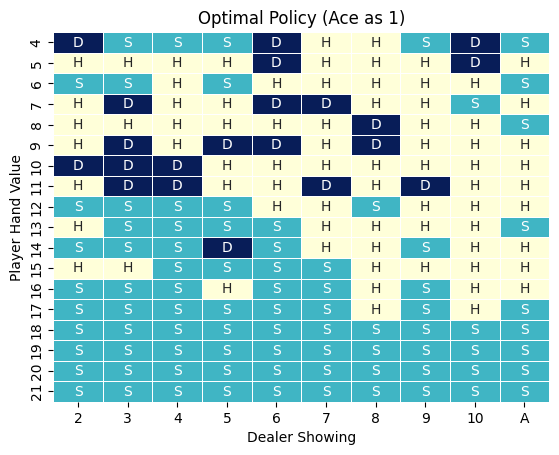

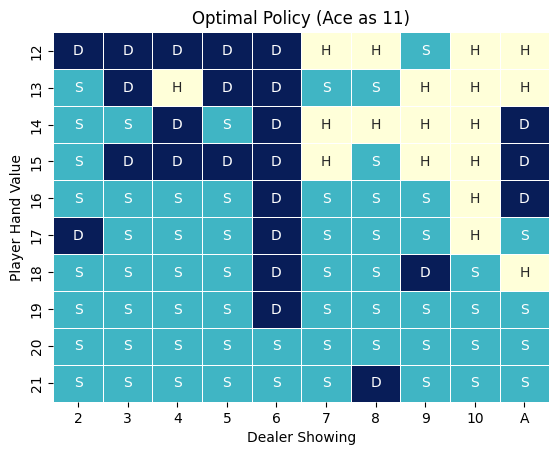

In [11]:
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm


ACTION_HIT = 0
ACTION_STAND = 1
ACTION_DOUBLE_DOWN = 2

ACTIONS = [ACTION_HIT, ACTION_STAND, ACTION_DOUBLE_DOWN ]
ACTION_NAMES = ['H', 'S', 'D']


CARD_VALUES = {
    '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10,
    'J': 10, 'Q': 10, 'K': 10, 'A': 11
}

class TwentyOneGame:
    def __init__(self):
        self.reset()

    def reset(self):
        self.deck = self.create_deck()
        self.player_hand = [self.deck.pop(), self.deck.pop()]
        self.dealer_hand = [self.deck.pop(), self.deck.pop()]
        return self.get_state()

    def create_deck(self):
        deck = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A'] * 4
        random.shuffle(deck)
        return deck

    def get_state(self):
        return (self.hand_value(self.player_hand), CARD_VALUES[self.dealer_hand[0]])

    def hand_value(self, hand):
        value = sum(CARD_VALUES[card] for card in hand)
        num_aces = hand.count('A')
        is_soft = False
        while value > 21 and num_aces:
            value -= 10
            num_aces -= 1
        if 'A' in hand and value <= 21:
            is_soft = True
        return value, is_soft

    def execute_action(self, action):
        if action == ACTION_HIT:
            card = self.deck.pop()
            self.player_hand.append(card)
            if self.hand_value(self.player_hand)[0] > 21:
                return self.get_state(), -1, True
        elif action == ACTION_STAND:
            while self.hand_value(self.dealer_hand)[0] < 17:
                self.dealer_hand.append(self.deck.pop())
            if self.hand_value(self.dealer_hand)[0] > 21 or self.hand_value(self.player_hand)[0] > self.hand_value(self.dealer_hand)[0]:
                return self.get_state(), 1, True
            elif self.hand_value(self.player_hand)[0] == self.hand_value(self.dealer_hand)[0]:
                return self.get_state(), 0, True
            else:
                return self.get_state(), -1, True
        elif action == ACTION_DOUBLE_DOWN:
            card = self.deck.pop()
            self.player_hand.append(card)
            if self.hand_value(self.player_hand)[0] > 21:
                return self.get_state(), -2, True
            else:
                while self.hand_value(self.dealer_hand)[0] < 17:
                    self.dealer_hand.append(self.deck.pop())
                if self.hand_value(self.dealer_hand)[0] > 21 or self.hand_value(self.player_hand)[0] > self.hand_value(self.dealer_hand)[0]:
                    return self.get_state(), 2, True
                elif self.hand_value(self.player_hand)[0] == self.hand_value(self.dealer_hand)[0]:
                    return self.get_state(), 0, True
                else:
                    return self.get_state(), -2, True
              
        return self.get_state(), 0, False  
       


env = TwentyOneGame()

def get_action_probabilities(Q_s, epsilon, n_actions):
    policy_s = np.ones(n_actions) * epsilon / n_actions
    best_action = np.argmax(Q_s)
    policy_s[best_action] = 1 - epsilon + (epsilon / n_actions)
    return policy_s

def update_q_values(games, Q, alpha, gamma):
    for state, action, reward in games:
        first_occurrence_idx = next(i for i, x in enumerate(games) if x[0] == state)
        G = sum([x[2] * (gamma ** i) for i, x in enumerate(games[first_occurrence_idx:])])
        Q[state][action] += alpha * (G - Q[state][action])
    return Q

def play_games(env, Q, epsilon, n_actions):
    games = []
    state = env.reset()
    done = False
    while not done:
        if state in Q:
            action_probabilities = get_action_probabilities(Q[state], epsilon, n_actions)
            action = np.random.choice(np.arange(n_actions), p=action_probabilities)
        else:
            action = random.choice(ACTIONS)
        next_state, reward, done = env.execute_action(action)
        games.append((state, action, reward))
        state = next_state
    return games

def monte_carlo_control(env, num_games):
    epsilon = 1.0
    epsilon_min = 0.01
    decay = 0.999
    alpha = 0.01
    gamma = 1.0

    n_actions = len(ACTIONS)
    Q = defaultdict(lambda: np.zeros(n_actions))

    wins, losses, ties = 0, 0, 0
    win_rates = []
    rewards = []

    for i_games in range(1, num_games + 1):
        if i_games % 10000 == 0:
            print(f"\rGames {i_games}/{num_games}.", end="")

        epsilon = max(epsilon * decay, epsilon_min)
        games = play_games(env, Q, epsilon, n_actions)
        Q = update_q_values(games, Q, alpha, gamma)

        _, _, reward = games[-1]
        rewards.append(reward)
        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            ties += 1

        if i_games % 100 == 0:
            win_rate = wins / i_games
            win_rates.append(win_rate)

    return Q, win_rates, rewards

def plot_optimal_policy(Q, ace_as_11):
    policy = np.zeros((22, 12), dtype=int)
    annotations = np.full((22, 12), '', dtype='<U1')
    player_range = range(12, 22) if ace_as_11 else range(4, 22)
    for player_total in player_range:
        for dealer_card in range(2, 12):
            state = ((player_total, ace_as_11), dealer_card)
            if state in Q:
                best_action = np.argmax(Q[state])
                policy[player_total, dealer_card] = best_action + 1
                annotations[player_total, dealer_card] = ACTION_NAMES[best_action]
    fig, ax = plt.subplots()
    sns.heatmap(policy[player_range, 2:12], annot=annotations[player_range, 2:12], fmt='', cbar=False, ax=ax, cmap="YlGnBu", linewidths=.5, xticklabels=['2', '3', '4', '5', '6', '7', '8', '9', '10', 'A'], yticklabels=list(player_range))
    ax.set_xlabel('Dealer Showing')
    ax.set_ylabel('Player Hand Value')
    ax.set_title(f'Optimal Policy (Ace as {"11" if ace_as_11 else "1"})')
    plt.show()

if __name__ == "__main__":
    
    num_games = 100000  
    env = TwentyOneGame()
    Q, win_rates, rewards = monte_carlo_control(env, num_games)

    
    def evaluate_policy(Q, num_eval_games=100000, interval=1000):
        wins, losses, ties = 0, 0, 0
        total_reward = 0.0
        win_rate_over_time = []
        cumulative_wins = 0
        for i_games in range(1, num_eval_games + 1):
            state = env.reset()
            done = False
            while not done:
                if state in Q:
                    action = np.argmax(Q[state])
                else:
                    action = random.choice(ACTIONS)
                state, reward, done = env.execute_action(action)
                total_reward += reward
                if done:
                    if reward > 0:
                        wins += 1
                        cumulative_wins += 1
                    elif reward < 0:
                        losses += 1
                    else:
                        ties += 1
            if i_games % interval == 0:
                win_rate = cumulative_wins / i_games
                win_rate_over_time.append(win_rate)
        win_rate = wins / num_eval_games
        avg_reward = total_reward / num_eval_games
        return win_rate, avg_reward, wins, losses, ties, win_rate_over_time

    win_rate, avg_reward, wins, losses, ties, win_rate_over_time = evaluate_policy(Q)

    print(f"Evaluation over {10000} games:")
    print(f"Win rate: {win_rate * 100:.2f}%")
    print(f"Average reward: {avg_reward:.2f}")
    print(f"Wins: {wins}, Losses: {losses}, Ties: {ties}")

    plot_optimal_policy(Q, ace_as_11=False)

    plot_optimal_policy(Q, ace_as_11=True)


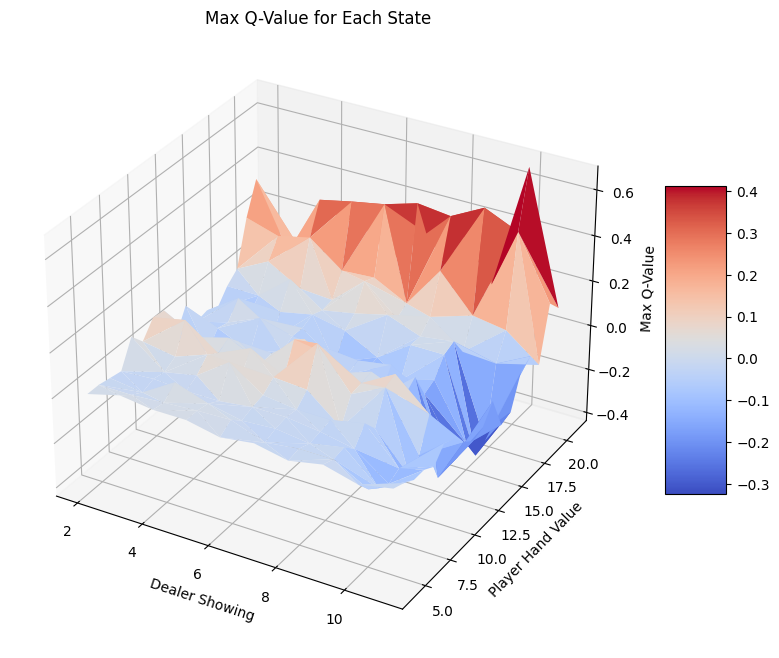

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm

def visualize_Q(Q):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    x = []
    y = []
    z = []

    for state, actions in Q.items():
        if isinstance(state[0], tuple) and isinstance(state[1], int):  # Ensure correct state structure
            player_value, is_soft = state[0]
            dealer_value = state[1]
            max_q = max(actions)
            x.append(dealer_value)
            y.append(player_value)
            z.append(max_q)

    x = np.array(x)
    y = np.array(y)
    z = np.array(z)

    surf = ax.plot_trisurf(x, y, z, cmap=cm.coolwarm, linewidth=0.2, antialiased=True)

    ax.set_xlabel('Dealer Showing')
    ax.set_ylabel('Player Hand Value')
    ax.set_zlabel('Max Q-Value')
    ax.set_title('Max Q-Value for Each State')

    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


env = TwentyOneGame()
num_eval_games = 10000
Q, _, _ = monte_carlo_control(env, num_eval_games)
visualize_Q(Q)


# Complete Point-Count System

Games 1000000/1000000.Evaluation over 10000 games:
Win rate: 42.78%
Average reward: -0.04
Wins: 4278, Losses: 4830, Ties: 892


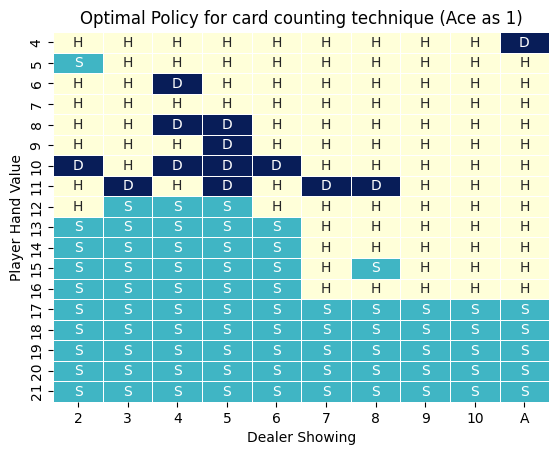

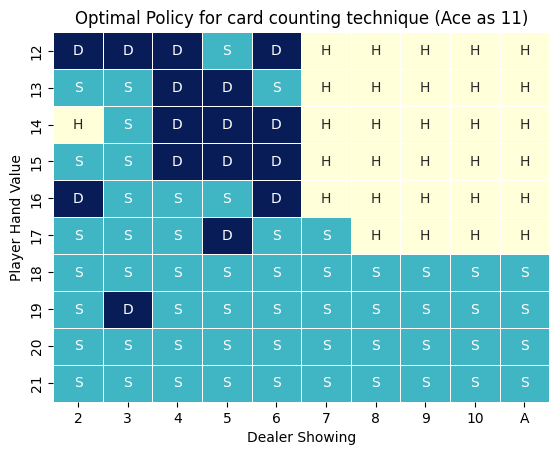

In [5]:
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm


ACTION_HIT = 0
ACTION_STAND = 1
ACTION_DOUBLE_DOWN = 2
ACTIONS = [ACTION_HIT, ACTION_STAND, ACTION_DOUBLE_DOWN ]
ACTION_NAMES = ['H', 'S', 'D']


CARD_VALUES = {
    '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10,
    'J': 10, 'Q': 10, 'K': 10, 'A': 11
}

HI_LO_VALUES = {
    '2': 1, '3': 1, '4': 1, '5': 1, '6': 1,
    '7': 0, '8': 0, '9': 0,
    '10': -1, 'J': -1, 'Q': -1, 'K': -1, 'A': -1
}

class TwentyOneGame:
    def __init__(self):
        self.reset()

    def reset(self):
        self.deck = self.create_deck()
        self.running_count = 0
        self.player_hand = [self.deck.pop(), self.deck.pop()]
        self.dealer_hand = [self.deck.pop(), self.deck.pop()]
        self.update_running_count(self.player_hand + self.dealer_hand)
        return self.get_state()

    def create_deck(self):
        deck = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A'] * 4
        random.shuffle(deck)
        return deck
    
    def update_running_count(self, cards):
        for card in cards:
            self.running_count += HI_LO_VALUES[card]

    def get_state(self):
        return (self.hand_value(self.player_hand), CARD_VALUES[self.dealer_hand[0]])
        return ((player_value, is_soft), CARD_VALUES[self.dealer_hand[0]], self.running_count)

    def hand_value(self, hand):
        value = sum(CARD_VALUES[card] for card in hand)
        num_aces = hand.count('A')
        is_soft = False
        while value > 21 and num_aces:
            value -= 10
            num_aces -= 1
        if 'A' in hand and value <= 21:
            is_soft = True
        return value, is_soft

    def execute_action(self, action):
        if action == ACTION_HIT:
            new_card = self.deck.pop()
            card = self.deck.pop()
            self.player_hand.append(new_card)
            self.update_running_count([new_card])
            if self.hand_value(self.player_hand)[0] > 21:
                return self.get_state(), -1, True
        elif action == ACTION_STAND:
            while self.hand_value(self.dealer_hand)[0] < 17:
                new_card = self.deck.pop()
                self.dealer_hand.append(new_card)
                self.update_running_count([new_card])
            if self.hand_value(self.dealer_hand)[0] > 21 or self.hand_value(self.player_hand)[0] > self.hand_value(self.dealer_hand)[0]:
                return self.get_state(), 1, True
            elif self.hand_value(self.player_hand)[0] == self.hand_value(self.dealer_hand)[0]:
                return self.get_state(), 0, True
            else:
                return self.get_state(), -1, True
        elif action == ACTION_DOUBLE_DOWN:
            new_card = self.deck.pop()
            self.player_hand.append(new_card)
            self.update_running_count([new_card])
            if self.hand_value(self.player_hand)[0] > 21:
                return self.get_state(), -2, True
            else:
                while self.hand_value(self.dealer_hand)[0] < 17:
                    new_card = self.deck.pop()
                    self.dealer_hand.append(new_card)
                    self.update_running_count([new_card])
                if self.hand_value(self.dealer_hand)[0] > 21 or self.hand_value(self.player_hand)[0] > self.hand_value(self.dealer_hand)[0]:
                    return self.get_state(), 2, True
                elif self.hand_value(self.player_hand)[0] == self.hand_value(self.dealer_hand)[0]:
                    return self.get_state(), 0, True
                else:
                    return self.get_state(), -2, True
       
        return self.get_state(), 0, False


env = TwentyOneGame()

def get_action_probabilities(Q_s, epsilon, n_actions):
    policy_s = np.ones(n_actions) * epsilon / n_actions
    best_action = np.argmax(Q_s)
    policy_s[best_action] = 1 - epsilon + (epsilon / n_actions)
    return policy_s

def update_q_values(games, Q, alpha, gamma):
    for state, action, reward in games:
        first_occurrence_idx = next(i for i, x in enumerate(games) if x[0] == state)
        G = sum([x[2] * (gamma ** i) for i, x in enumerate(games[first_occurrence_idx:])])
        Q[state][action] += alpha * (G - Q[state][action])
    return Q

def play_games(env, Q, epsilon, n_actions):
    games = []
    state = env.reset()
    done = False
    while not done:
        if state in Q:
            action_probabilities = get_action_probabilities(Q[state], epsilon, n_actions)
            action = np.random.choice(np.arange(n_actions), p=action_probabilities)
        else:
            action = random.choice(ACTIONS)
        next_state, reward, done = env.execute_action(action)
        games.append((state, action, reward))
        state = next_state
    return games

def monte_carlo_control(env, num_games):
    epsilon = 1.0
    epsilon_min = 0.01
    decay = 0.999
    alpha = 0.01
    gamma = 1.0

    n_actions = len(ACTIONS)
    Q = defaultdict(lambda: np.zeros(n_actions))

    wins, losses, ties = 0, 0, 0
    win_rates = []
    rewards = []

    for i_games in range(1, num_games + 1):
        if i_games % 100000 == 0:
            print(f"\rGames {i_games}/{num_games}.", end="")

        epsilon = max(epsilon * decay, epsilon_min)
        games = play_games(env, Q, epsilon, n_actions)
        Q = update_q_values(games, Q, alpha, gamma)

        _, _, reward = games[-1]
        rewards.append(reward)
        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            ties += 1

        if i_games % 100 == 0:
            win_rate = wins / i_games
            win_rates.append(win_rate)

    return Q, win_rates, rewards

def plot_optimal_policy(Q, ace_as_11):
    policy = np.zeros((22, 12), dtype=int)
    annotations = np.full((22, 12), '', dtype='<U1')
    player_range = range(12, 22) if ace_as_11 else range(4, 22)
    for player_total in player_range:
        for dealer_card in range(2, 12):
            state = ((player_total, ace_as_11), dealer_card)
            if state in Q:
                best_action = np.argmax(Q[state])
                policy[player_total, dealer_card] = best_action + 1
                annotations[player_total, dealer_card] = ACTION_NAMES[best_action]
    fig, ax = plt.subplots()
    sns.heatmap(policy[player_range, 2:12], annot=annotations[player_range, 2:12], fmt='', cbar=False, ax=ax, cmap="YlGnBu", linewidths=.5, xticklabels=['2', '3', '4', '5', '6', '7', '8', '9', '10', 'A'], yticklabels=list(player_range))
    ax.set_xlabel('Dealer Showing')
    ax.set_ylabel('Player Hand Value')
    ax.set_title(f'Optimal Policy for card counting technique (Ace as {"11" if ace_as_11 else "1"})')
    plt.show()

if __name__ == "__main__":
    
    num_games = 1000000  
    env = TwentyOneGame()
    Q, win_rates, rewards = monte_carlo_control(env, num_games)

    def evaluate_policy(Q, num_eval_games=10000, interval=1000):
        wins, losses, ties = 0, 0, 0
        total_reward = 0.0
        win_rate_over_time = []
        cumulative_wins = 0
        for i_games in range(1, num_eval_games + 1):
            state = env.reset()
            done = False
            while not done:
                if state in Q:
                    action = np.argmax(Q[state])
                else:
                    action = random.choice(ACTIONS)
                state, reward, done = env.execute_action(action)
                total_reward += reward
                if done:
                    if reward > 0:
                        wins += 1
                        cumulative_wins += 1
                    elif reward < 0:
                        losses += 1
                    else:
                        ties += 1
            if i_games % interval == 0:
                win_rate = cumulative_wins / i_games
                win_rate_over_time.append(win_rate)
        win_rate = wins / num_eval_games
        avg_reward = total_reward / num_eval_games
        return win_rate, avg_reward, wins, losses, ties, win_rate_over_time

    win_rate, avg_reward, wins, losses, ties, win_rate_over_time = evaluate_policy(Q)

    print(f"Evaluation over {10000} games:")
    print(f"Win rate: {win_rate * 100:.2f}%")
    print(f"Average reward: {avg_reward:.2f}")
    print(f"Wins: {wins}, Losses: {losses}, Ties: {ties}")

    
    plot_optimal_policy(Q, ace_as_11=False)

    plot_optimal_policy(Q, ace_as_11=True)

Games 1000000/1000000.

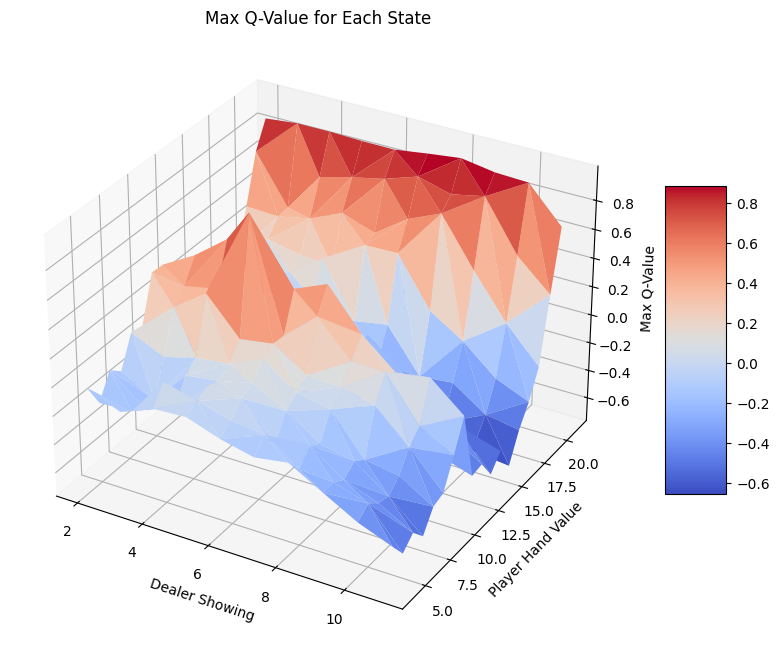

In [14]:
def visualize_Q(Q):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    x = []
    y = []
    z = []

    for state, actions in Q.items():
        if isinstance(state[0], tuple) and isinstance(state[1], int):  # Ensure correct state structure
            player_value, is_soft = state[0]
            dealer_value = state[1]
            max_q = max(actions)
            x.append(dealer_value)
            y.append(player_value)
            z.append(max_q)

    x = np.array(x)
    y = np.array(y)
    z = np.array(z)

    surf = ax.plot_trisurf(x, y, z, cmap=cm.coolwarm, linewidth=0.2, antialiased=True)

    ax.set_xlabel('Dealer Showing')
    ax.set_ylabel('Player Hand Value')
    ax.set_zlabel('Max Q-Value')
    ax.set_title('Max Q-Value for Each State(card counting technique)')

    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    
env = TwentyOneGame()
num_eval_games = 1000000
Q, _, _ = monte_carlo_control(env, num_eval_games)
visualize_Q(Q)

# Rule Variations
# 1. Dealer Hits Soft 17
# 2. Double Anytime

Episode 100000/100000.

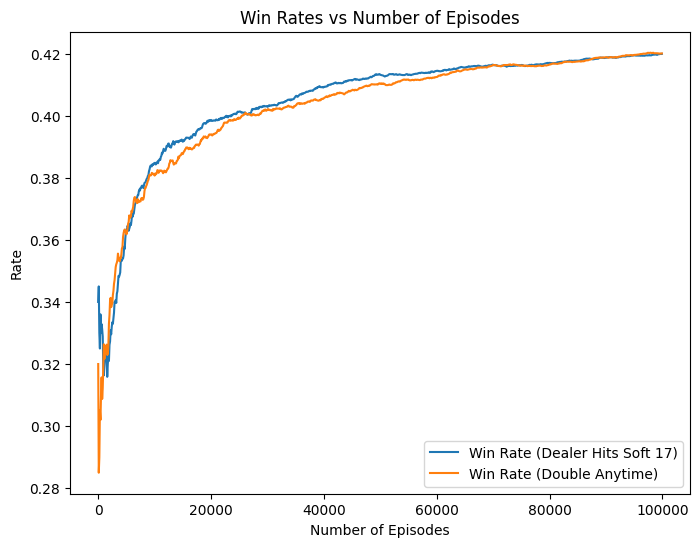


After 100000 episodes (Dealer Hits Soft 17):
Final Win rate: 41.99%
Final Loss rate: 50.89%
Final Tie rate: 7.13%

After 100000 episodes (Double Anytime):
Final Win rate: 42.00%
Final Loss rate: 50.94%
Final Tie rate: 7.05%


In [18]:
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import cm



ACTION_HIT = 0
ACTION_STAND = 1
ACTION_DOUBLE_DOWN = 2
ACTION_SPACE = [ACTION_HIT, ACTION_STAND, ACTION_DOUBLE_DOWN ]


CARD_VALUES = {
    '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10,
    'J': 10, 'Q': 10, 'K': 10, 'A': 11
}


HI_LO_VALUES = {
    '2': 1, '3': 1, '4': 1, '5': 1, '6': 1,
    '7': 0, '8': 0, '9': 0,
    '10': -1, 'J': -1, 'Q': -1, 'K': -1, 'A': -1
}

class TwentyOneGame:
    def __init__(self, dealer_hits_soft_17=True, double_anytime=False):
        self.dealer_hits_soft_17 = dealer_hits_soft_17
        self.double_anytime = double_anytime
        self.reset()

    def reset(self):
        self.deck = self.create_deck()
        self.running_count = 0
        self.player_hand = [self.deck.pop(), self.deck.pop()]
        self.dealer_hand = [self.deck.pop(), self.deck.pop()]
        self.update_running_count(self.player_hand + self.dealer_hand)
        return self.get_state()

    def create_deck(self):
        deck = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A'] * 4
        random.shuffle(deck)
        return deck

    def update_running_count(self, cards):
        for card in cards:
            self.running_count += HI_LO_VALUES[card]

    def get_state(self):
        player_value, is_soft = self.hand_value(self.player_hand)
        return ((player_value, is_soft), CARD_VALUES[self.dealer_hand[0]], self.running_count)

    def hand_value(self, hand):
        value = sum(CARD_VALUES[card] for card in hand)
        num_aces = hand.count('A')
        is_soft = False
        while value > 21 and num_aces:
            value -= 10
            num_aces -= 1
        if 'A' in hand and value <= 21:
            is_soft = True
        return value, is_soft

    def execute_action(self, action):
        if action == ACTION_HIT:
            new_card = self.deck.pop()
            self.player_hand.append(new_card)
            self.update_running_count([new_card])
            if self.hand_value(self.player_hand)[0] > 21:
                return self.get_state(), -1, True
        elif action == ACTION_STAND:
            while self.hand_value(self.dealer_hand)[0] < 17 or (self.hand_value(self.dealer_hand)[0] == 17 and self.dealer_hits_soft_17 and 'A' in self.dealer_hand):
                new_card = self.deck.pop()
                self.dealer_hand.append(new_card)
                self.update_running_count([new_card])
            if self.hand_value(self.dealer_hand)[0] > 21 or self.hand_value(self.player_hand)[0] > self.hand_value(self.dealer_hand)[0]:
                return self.get_state(), 1, True
            elif self.hand_value(self.player_hand)[0] == self.hand_value(self.dealer_hand)[0]:
                return self.get_state(), 0, True
            else:
                return self.get_state(), -1, True
        elif action == ACTION_DOUBLE_DOWN:
            new_card = self.deck.pop()
            self.player_hand.append(new_card)
            self.update_running_count([new_card])
            if self.hand_value(self.player_hand)[0] > 21:
                return self.get_state(), -2, True
            else:
                while self.hand_value(self.dealer_hand)[0] < 17 or (self.hand_value(self.dealer_hand)[0] == 17 and self.dealer_hits_soft_17 and 'A' in self.dealer_hand):
                    new_card = self.deck.pop()
                    self.dealer_hand.append(new_card)
                    self.update_running_count([new_card])
                if self.hand_value(self.dealer_hand)[0] > 21 or self.hand_value(self.player_hand)[0] > self.hand_value(self.dealer_hand)[0]:
                    return self.get_state(), 2, True
                elif self.hand_value(self.player_hand)[0] == self.hand_value(self.dealer_hand)[0]:
                    return self.get_state(), 0, True
                else:
                    return self.get_state(), -2, True
        
        return self.get_state(), 0, False


env = TwentyOneGame(dealer_hits_soft_17=True, double_anytime=False)
env_double_anytime = TwentyOneGame(dealer_hits_soft_17=True, double_anytime=True)

def get_action_probabilities(Qstate, epsilon, n_actions):
    policy_s = np.ones(n_actions) * epsilon / n_actions
    best_a = np.argmax(Qstate)
    policy_s[best_a] = 1 - epsilon + (epsilon / n_actions)
    return policy_s

def update_Q(games, Q, alpha, gamma):
    for s, a, r in games:
        first_occurrence_idx = next(i for i, x in enumerate(games) if x[0] == s)
        G = sum([x[2] * (gamma ** i) for i, x in enumerate(games[first_occurrence_idx:])])
        Q[s][a] = Q[s][a] + alpha * (G - Q[s][a])
    return Q

def play_episode(env, Q, epsilon, n_actions):
    games = []
    state = env.reset()
    done = False
    while not done:
        if state in Q:
            probs = get_action_probabilities(Q[state], epsilon, n_actions)
            action = np.random.choice(np.arange(n_actions), p=probs)
        else:
            action = random.choice(ACTION_SPACE)
        next_state, reward, done = env.execute_action(action)
        games.append((state, action, reward))
        state = next_state
    return games

def monte_carlo_control(env, num_games):
    epsilon = 1.0
    eps_min = 0.01
    decay = 0.999  
    alpha = 0.01
    gamma = 1.0

    n_actions = len(ACTION_SPACE)
    Q = defaultdict(lambda: np.zeros(n_actions))

    wins, losses, ties = 0, 0, 0
    win_rates = []
    loss_rates = []
    tie_rates = []

    for i_episode in range(1, num_games + 1):
        if i_episode % 10000 == 0:
            print(f"\rgames {i_episode}/{num_games}.", end="")

        epsilon = max(epsilon * decay, eps_min)
        games = play_episode(env, Q, epsilon, n_actions)
        Q = update_Q(games, Q, alpha, gamma)

        
        _, _, reward = games[-1]
        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            ties += 1

        if i_episode % 100 == 0:
            win_rate = wins / i_episode
            loss_rate = losses / i_episode
            tie_rate = ties / i_episode
            win_rates.append(win_rate)
            loss_rates.append(loss_rate)
            tie_rates.append(tie_rate)

    return Q, win_rates, loss_rates, tie_rates


num_games = 100000 
Q_soft_17, win_rates_soft_17, loss_rates_soft_17, tie_rates_soft_17 = monte_carlo_control(env, num_games)
Q_double_anytime, win_rates_double_anytime, loss_rates_double_anytime, tie_rates_double_anytime = monte_carlo_control(env_double_anytime, num_games)


plt.figure(figsize=(8, 6))
plt.plot(range(0, num_games, 100), win_rates_soft_17, label='Win Rate (Dealer Hits Soft 17)')
plt.plot(range(0, num_games, 100), win_rates_double_anytime, label='Win Rate (Double Anytime)')
plt.xlabel('Number of games')
plt.ylabel('Rate')
plt.title('Win Rates vs Number of games')
plt.legend()
plt.show()

print(f"\nAfter {num_games}games (Dealer Hits Soft 17):")
print(f"Final Win rate: {win_rates_soft_17[-1] * 100:.2f}%")
print(f"Final Loss rate: {loss_rates_soft_17[-1] * 100:.2f}%")
print(f"Final Tie rate: {tie_rates_soft_17[-1] * 100:.2f}%")

print(f"\nAfter {num_games} games (Double Anytime):")
print(f"Final Win rate: {win_rates_double_anytime[-1] * 100:.2f}%")
print(f"Final Loss rate: {loss_rates_double_anytime[-1] * 100:.2f}%")
print(f"Final Tie rate: {tie_rates_double_anytime[-1] * 100:.2f}%")


# Betting Strategy¶
 Improving the Complete Point-Count System by Betting Strategy 

In [19]:
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

ACTION_HIT = 0
ACTION_STAND = 1
ACTION_DOUBLE_DOWN = 2
ACTIONS = [ACTION_HIT, ACTION_STAND, ACTION_DOUBLE_DOWN]

CARD_VALUES = {
    '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10,
    'J': 10, 'Q': 10, 'K': 10, 'A': 11
}

HI_LO_VALUES = {
    '2': 1, '3': 1, '4': 1, '5': 1, '6': 1,
    '7': 0, '8': 0, '9': 0,
    '10': -1, 'J': -1, 'Q': -1, 'K': -1, 'A': -1
}

class TwentyOneGame:
    def __init__(self):
        self.reset()

    def reset(self):
        self.deck = self.create_deck()
        self.running_count = 0
        self.player_hand = [self.deck.pop(), self.deck.pop()]
        self.dealer_hand = [self.deck.pop(), self.deck.pop()]
        self.update_running_count(self.player_hand + self.dealer_hand)
        return self.get_state()

    def create_deck(self):
        deck = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A'] * 4
        random.shuffle(deck)
        return deck

    def update_running_count(self, cards):
        for card in cards:
            self.running_count += HI_LO_VALUES[card]

    def get_true_count(self):
        decks_remaining = len(self.deck) / 52.0
        return self.running_count / decks_remaining

    def get_state(self):
        player_value, is_soft = self.calculate_hand_value(self.player_hand)
        true_count = self.get_true_count()
        return ((player_value, is_soft), CARD_VALUES[self.dealer_hand[0]], int(true_count))

    def calculate_hand_value(self, hand):
        value = sum(CARD_VALUES[card] for card in hand)
        num_aces = hand.count('A')
        is_soft = False
        while value > 21 and num_aces:
            value -= 10
            num_aces -= 1
        if 'A' in hand and value <= 21:
            is_soft = True
        return value, is_soft

    def execute_action(self, action):
        if action == ACTION_HIT:
            new_card = self.deck.pop()
            self.player_hand.append(new_card)
            self.update_running_count([new_card])
            if self.calculate_hand_value(self.player_hand)[0] > 21:
                return self.get_state(), -1, True
        elif action == ACTION_STAND:
            while self.calculate_hand_value(self.dealer_hand)[0] < 17:
                new_card = self.deck.pop()
                self.dealer_hand.append(new_card)
                self.update_running_count([new_card])
            if self.calculate_hand_value(self.dealer_hand)[0] > 21 or self.calculate_hand_value(self.player_hand)[0] > self.calculate_hand_value(self.dealer_hand)[0]:
                return self.get_state(), 1, True
            elif self.calculate_hand_value(self.player_hand)[0] == self.calculate_hand_value(self.dealer_hand)[0]:
                return self.get_state(), 0, True
            else:
                return self.get_state(), -1, True
        elif action == ACTION_DOUBLE_DOWN:
            new_card = self.deck.pop()
            self.player_hand.append(new_card)
            self.update_running_count([new_card])
            if self.calculate_hand_value(self.player_hand)[0] > 21:
                return self.get_state(), -2, True
            else:
                while self.calculate_hand_value(self.dealer_hand)[0] < 17:
                    new_card = self.deck.pop()
                    self.dealer_hand.append(new_card)
                    self.update_running_count([new_card])
                if self.calculate_hand_value(self.dealer_hand)[0] > 21 or self.calculate_hand_value(self.player_hand)[0] > self.calculate_hand_value(self.dealer_hand)[0]:
                    return self.get_state(), 2, True
                elif self.calculate_hand_value(self.player_hand)[0] == self.calculate_hand_value(self.dealer_hand)[0]:
                    return self.get_state(), 0, True
                else:
                    return self.get_state(), -2, True
        
        return self.get_state(), 0, False

env = TwentyOneGame()

def get_action_probabilities(Q_s, epsilon, n_actions):
    policy_s = np.ones(n_actions) * epsilon / n_actions
    best_action = np.argmax(Q_s)
    policy_s[best_action] = 1 - epsilon + (epsilon / n_actions)
    return policy_s

def update_q_values(games, Q, alpha, gamma):
    for state, action, reward in games:
        first_occurrence_idx = next(i for i, x in enumerate(games) if x[0] == state)
        G = sum([x[2] * (gamma ** i) for i, x in enumerate(games[first_occurrence_idx:])])
        Q[state][action] += alpha * (G - Q[state][action])
    return Q

def play_games(env, Q, epsilon, n_actions):
    games = []
    state = env.reset()
    done = False
    while not done:
        if state in Q:
            action_probabilities = get_action_probabilities(Q[state], epsilon, n_actions)
            action = np.random.choice(np.arange(n_actions), p=action_probabilities)
        else:
            action = random.choice(ACTIONS)
        next_state, reward, done = env.execute_action(action)
        games.append((state, action, reward))
        state = next_state
    return games

def monte_carlo_control(env, num_games):
    epsilon = 1.0
    epsilon_min = 0.01
    decay = 0.9995
    alpha = 0.02
    gamma = 1.0

    n_actions = len(ACTIONS)
    Q = defaultdict(lambda: np.zeros(n_actions))

    wins, losses, ties = 0, 0, 0
    win_rates = []
    rewards = []
    bet_sizes = []

    for i_games in range(1, num_games + 1):
        if i_games % 10000 == 0:
            print(f"\rGames {i_games}/{num_games}.", end="")

        epsilon = max(epsilon * decay, epsilon_min)
        games = play_games(env, Q, epsilon, n_actions)
        Q = update_q_values(games, Q, alpha, gamma)

        _, _, reward = games[-1]
        rewards.append(reward)
        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            ties += 1

        true_count = env.get_true_count()
        bet_size = max(1, min(20, int(np.exp(true_count / 3))))  # Adjusted exponential betting strategy
        bet_sizes.append(bet_size)

        if i_games % 100 == 0:
            win_rate = wins / i_games
            win_rates.append(win_rate)

    return Q, win_rates, rewards, bet_sizes, wins, losses, ties


if __name__ == "__main__":
    
    num_games = 100000
    env = TwentyOneGame()
    Q, win_rates, rewards, bet_sizes, wins, losses, ties = monte_carlo_control(env, num_games)

    print(f"After {num_games} games:")
    print(f"Win rate: {win_rates[-1] * 100:.2f}%")
    print(f"Loss rate: {losses / num_games * 100:.2f}%")
    print(f"Tie rate: {ties / num_games * 100:.2f}%")


Games 100000/100000.After 100000 games:
Win rate: 41.87%
Loss rate: 50.77%
Tie rate: 7.36%


# Implementation of a self-learning BlackJack for a basic strategy for Different Gamma Values

Games 100000/100000.

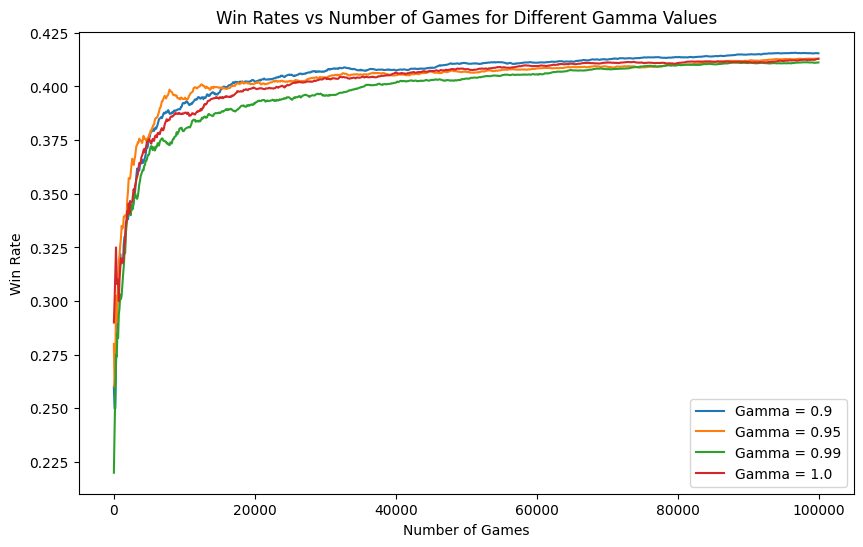

In [20]:
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm


ACTION_HIT = 0
ACTION_STAND = 1
ACTION_DOUBLE_DOWN = 2
ACTION_SPLIT = 3
ACTIONS = [ACTION_HIT, ACTION_STAND, ACTION_DOUBLE_DOWN ]
ACTION_NAMES = ['H', 'S', 'D']


CARD_VALUES = {
    '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10,
    'J': 10, 'Q': 10, 'K': 10, 'A': 11
}

class TwentyOneGame:
    def __init__(self):
        self.reset()

    def reset(self):
        self.deck = self.create_deck()
        self.player_hand = [self.deck.pop(), self.deck.pop()]
        self.dealer_hand = [self.deck.pop(), self.deck.pop()]
        return self.get_state()

    def create_deck(self):
        deck = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A'] * 4
        random.shuffle(deck)
        return deck

    def get_state(self):
        return (self.hand_value(self.player_hand), CARD_VALUES[self.dealer_hand[0]])

    def hand_value(self, hand):
        value = sum(CARD_VALUES[card] for card in hand)
        num_aces = hand.count('A')
        is_soft = False
        while value > 21 and num_aces:
            value -= 10
            num_aces -= 1
        if 'A' in hand and value <= 21:
            is_soft = True
        return value, is_soft

    def execute_action(self, action):
        if action == ACTION_HIT:
            card = self.deck.pop()
            self.player_hand.append(card)
            if self.hand_value(self.player_hand)[0] > 21:
                return self.get_state(), -1, True
        elif action == ACTION_STAND:
            while self.hand_value(self.dealer_hand)[0] < 17:
                self.dealer_hand.append(self.deck.pop())
            if self.hand_value(self.dealer_hand)[0] > 21 or self.hand_value(self.player_hand)[0] > self.hand_value(self.dealer_hand)[0]:
                return self.get_state(), 1, True
            elif self.hand_value(self.player_hand)[0] == self.hand_value(self.dealer_hand)[0]:
                return self.get_state(), 0, True
            else:
                return self.get_state(), -1, True
        elif action == ACTION_DOUBLE_DOWN:
            card = self.deck.pop()
            self.player_hand.append(card)
            if self.hand_value(self.player_hand)[0] > 21:
                return self.get_state(), -2, True
            else:
                while self.hand_value(self.dealer_hand)[0] < 17:
                    self.dealer_hand.append(self.deck.pop())
                if self.hand_value(self.dealer_hand)[0] > 21 or self.hand_value(self.player_hand)[0] > self.hand_value(self.dealer_hand)[0]:
                    return self.get_state(), 2, True
                elif self.hand_value(self.player_hand)[0] == self.hand_value(self.dealer_hand)[0]:
                    return self.get_state(), 0, True
                else:
                    return self.get_state(), -2, True
       
        return self.get_state(), 0, False

env = TwentyOneGame()

def get_action_probabilities(Q_s, epsilon, n_actions):
    policy_s = np.ones(n_actions) * epsilon / n_actions
    best_action = np.argmax(Q_s)
    policy_s[best_action] = 1 - epsilon + (epsilon / n_actions)
    return policy_s

def update_q_values(games, Q, alpha, gamma):
    for state, action, reward in games:
        first_occurrence_idx = next(i for i, x in enumerate(games) if x[0] == state)
        G = sum([x[2] * (gamma ** i) for i, x in enumerate(games[first_occurrence_idx:])])
        Q[state][action] += alpha * (G - Q[state][action])
    return Q

def play_games(env, Q, epsilon, n_actions):
    games = []
    state = env.reset()
    done = False
    while not done:
        if state in Q:
            action_probabilities = get_action_probabilities(Q[state], epsilon, n_actions)
            action = np.random.choice(np.arange(n_actions), p=action_probabilities)
        else:
            action = random.choice(ACTIONS)
        next_state, reward, done = env.execute_action(action)
        games.append((state, action, reward))
        state = next_state
    return games

def monte_carlo_control(env, num_games, gamma):
    epsilon = 1.0
    epsilon_min = 0.01
    decay = 0.999
    alpha = 0.01

    n_actions = len(ACTIONS)
    Q = defaultdict(lambda: np.zeros(n_actions))

    wins, losses, ties = 0, 0, 0
    win_rates = []

    for i_games in range(1, num_games + 1):
        if i_games % 10000 == 0:
            print(f"\rGames {i_games}/{num_games}.", end="")

        epsilon = max(epsilon * decay, epsilon_min)
        games = play_games(env, Q, epsilon, n_actions)
        Q = update_q_values(games, Q, alpha, gamma)

        _, _, reward = games[-1]
        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            ties += 1

        if i_games % 100 == 0:
            win_rate = wins / i_games
            win_rates.append(win_rate)

    return Q, win_rates

num_games = 100000
gamma_values = [0.9, 0.95, 0.99, 1.0]
win_rates_gamma = {}

for gamma in gamma_values:
    _, win_rates = monte_carlo_control(env, num_games, gamma)
    win_rates_gamma[gamma] = win_rates


plt.figure(figsize=(10, 6))
for gamma, win_rates in win_rates_gamma.items():
    plt.plot(range(0, num_games, 100), win_rates, label=f'Gamma = {gamma}')
plt.xlabel('Number of Games')
plt.ylabel('Win Rate')
plt.title('Win Rates vs Number of Games for Different Gamma Values')
plt.legend()
plt.show()
